## Материалы:
* [Презентация] (https://drive.google.com/file/d/1z45MVT0j2xHeZMLp6ydfy1sTENUTLtPI/view?usp=sharing)
* [Дашборд] (https://public.tableau.com/app/profile/valeriya3733/viz/Final_project_16530791998300/Dashboard1)

## Описание проекта

**Название проекта:**

Ритейл — Анализ программы лояльности

**Описание исследования:**

В магазине строительных материалов «Строили, строили и наконец построили» все покупатели могут получить доступ к нему с использованием персональных карт. За 200 рублей в месяц они могут стать участниками программы лояльности. В программу включены скидки, специальные предложения, подарки. Необходимо провести анализ данных и предоставить результаты и рекомендации руководству магазина.
На основании анализа будут сделаны выводы и при необходимости приняты управленческие решения для корректировки программы лояльности.

**Цель исследования:**

Провести анализ программы лояльности


**Задачи исследования:**

Проанализировать программу лояльности магазина.

- Провести исследовательский анализ данных;
- Провести анализ программы лояльности;
- Сформулировать и проверьте статистические гипотезы.

**Исходные данные:**

Файл retail_dataset.csv:

- `purchaseId` — id чека;
- `item_ID` — id товара;
- `purchasedate` — дата покупки;
- `Quantity` — количество товара;
- `CustomerID` — id покупателя;
- `ShopID` — id магазина;
- `loyalty_program` — участвует ли покупатель в программе лояльности;


Файл product_codes.csv:

- `productID` — id товара;
- `price_per_one` — стоимость одной единицы товара

## Знакомство с данными и первичная обработка

In [1]:
# импортируем необходимые библиотеки

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st

In [2]:
# загрузим данные

data = pd.read_csv('/datasets/retail_dataset.csv')
product = pd.read_csv('/datasets/product_codes.csv')

In [3]:
# введем функцию для знакомства и первичной обработки базы данных

def inspect(df):
    display(df.head()) # вывод первых 5 строк таблицы
    df.info() # получение информации
    print ('Количество дубликатов -', df.duplicated().sum()) # вывод результата поиска дубликатов
    df.columns = [x.lower().replace(' ', '_') for x in df.columns.values] # корректировка названий столбцов
    display(df.describe()) #посмотрю основные статистические данные
    return df

In [4]:
# ознакомимся с базой данных по всем покупкам

data = inspect(data)

,purchaseid,item_ID,Quantity,purchasedate,CustomerID,ShopID,loyalty_program
0,538280,21873,11,2016-12-10 12:50:00,18427.0,Shop 0,0.0
1,538862,22195,0,2016-12-14 14:11:00,22389.0,Shop 0,1.0
2,538855,21239,7,2016-12-14 13:50:00,22182.0,Shop 0,1.0
3,543543,22271,0,2017-02-09 15:33:00,23522.0,Shop 0,1.0
4,543812,79321,0,2017-02-13 14:40:00,23151.0,Shop 0,1.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105335 entries, 0 to 105334
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   purchaseid       105335 non-null  object 
 1   item_ID          105335 non-null  object 
 2   Quantity         105335 non-null  int64  
 3   purchasedate     105335 non-null  object 
 4   CustomerID       69125 non-null   float64
 5   ShopID           105335 non-null  object 
 6   loyalty_program  105335 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 5.6+ MB
Количество дубликатов - 1033


,quantity,customerid,loyalty_program
count,105335.000000,69125.000000,105335.000000
mean,7.821218,21019.302047,0.226345
std,327.946695,1765.444679,0.418467
min,-74216.000000,18025.000000,0.000000
25%,0.000000,19544.000000,0.000000
50%,2.000000,20990.000000,0.000000
75%,7.000000,22659.000000,0.000000
max,74214.000000,23962.000000,1.000000


In [5]:
# скорректирую типы данных: дату покупки и статус участия в программе лояльности


data['purchasedate'] = pd.to_datetime(data['purchasedate']).dt.date
data['purchasedate'] = pd.to_datetime(data['purchasedate'], format='%Y-%m-%d')
data['loyalty_program'] = data['loyalty_program'].astype(int)
data['customerid'] = data['customerid'].astype(object)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105335 entries, 0 to 105334
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   purchaseid       105335 non-null  object        
 1   item_id          105335 non-null  object        
 2   quantity         105335 non-null  int64         
 3   purchasedate     105335 non-null  datetime64[ns]
 4   customerid       69125 non-null   object        
 5   shopid           105335 non-null  object        
 6   loyalty_program  105335 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 5.6+ MB


Пропуски в customerid рассмотрю дальше, после объединения таблиц. Хочу их немного проанализировать.

1033 дубликатов могут действительно быть, когда пробивают один и тот же товар разными строками в чеке. Удалять не нужно.

Есть позиции в чеке, где количество равно 0. Это похоже на ошибку. В реальности этот вопрос можно было бы выяснить, но в рамках проекта понять точно, что значат эти нули не имею возможности, но при этом они могут исказить статистику, например, при расчете среднего чека.

In [6]:
# удаляю строки, в которых количество равно 0

data = data[data['quantity'] != 0]

In [7]:
# ознакомимся с базой данных по всем покупкам

product = inspect(product)

,productID,price_per_one
0,85123A,2.55
1,71053,3.39
2,84406B,2.75
3,84029G,3.39
4,84029E,3.39


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9969 entries, 0 to 9968
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   productID      9969 non-null   object 
 1   price_per_one  9969 non-null   float64
dtypes: float64(1), object(1)
memory usage: 155.9+ KB
Количество дубликатов - 0


,price_per_one
count,9969.000000
mean,19.503697
std,330.880754
min,0.000000
25%,1.250000
50%,2.550000
75%,5.510000
max,16888.020000


Пропусков и дубликатов нет, с типами данных все в порядке

In [8]:
# посмотрим, сколько уникальных значений есть в столбце с ID продукта

product['productid'].nunique(dropna = True)

3159

Получается, что на 1 продукт может приходиться несколько цен. Такое вполне может быть, так как цены динамичны и могут меняться в зависимости от совокупности факторов.

In [9]:
# мне нужно оставить одну цену, чтобы объединить таблицы. 
# оставлю медианное значение

last_price = product.groupby(['productid']).median().reset_index()
last_price = last_price.rename(columns={'productid': 'item_id'}) # переименую столбец для объединения
last_price.head(5)

,item_id,price_per_one
0,10002,1.63
1,10080,0.85
2,10120,0.21
3,10123C,0.65
4,10124A,0.42


In [10]:
# объединю таблицы и сразу же добавлю столбец с суммой позиции в чеке

data_new = pd.merge(data, last_price, how='left', on='item_id')
data_new['sum_item'] = data_new['quantity'] * data_new['price_per_one']
data_new.head()

,purchaseid,item_id,quantity,purchasedate,customerid,shopid,loyalty_program,price_per_one,sum_item
0,538280,21873,11,2016-12-10,18427.0,Shop 0,0,1.630,17.930
1,538855,21239,7,2016-12-14,22182.0,Shop 0,1,1.630,11.410
2,541424,79321,1,2017-01-17,NaN,Shop 0,0,5.750,5.750
3,537795,82494L,5,2016-12-08,22892.0,Shop 0,1,5.205,26.025
4,541696,22197,4,2017-01-20,NaN,Shop 0,0,1.240,4.960


Пропуски есть в колонке customerid, 36210 шт. По условию: "Все покупатели могут получить доступ в магазин с использованием персональных карт." А соответственно, у всех покупателей должен быть id. Тогда предполагаю, что это могут быть строки для внутреннего пользования. Внутренние операции, которые нам для анализа не нужны.

Нужно принять решение, удалять ли эти значения. Поэтому я дополнительно посмотрю, что это за строки.

In [11]:
# отберу только строки, в которых данные покупателя не указаны

drop_customerid_0 = data_new[data_new.isnull().any(1)]

# сгруппирую по товару, отсортирую по убыванию суммы покупки

drop_itemid_0 = drop_customerid_0.groupby('item_id').agg({'sum_item': 'sum'})
drop_itemid_0 = drop_itemid_0.sort_values(by='sum_item', ascending=False).reset_index()
drop_itemid_0

,item_id,sum_item
0,POST,12925.05
1,21479,10921.44
2,22423,7386.30
3,22114,6615.42
4,22086,4364.10
...,...,...
2009,BANK CHARGES,-1987.44
2010,84997C,-2685.00
2011,21621,-3924.72
2012,22617,-11960.00


Судя по группировке по item_id, максимальные и минимальные значения - это POST, BANK CHARGES и AMAZONFEE, особенно последнее значение самое крупное. А это всевозможные комиссии, то есть как раз внутренние операции.
Поэтому удалю все строки, где не определено id покупателя.

In [12]:
data_new = data_new.dropna(subset=['customerid'])

## Исследовательский анализ данных

### Анализ магазинов

In [13]:
# сведу все данные по магазинам

shops = data_new.groupby('shopid').agg({'purchaseid': 'nunique', 'item_id': 'nunique', 
                                        'quantity': 'sum', 'customerid': 'nunique', 
                                        'purchasedate': ['min', 'max'], 'loyalty_program': 'sum', 
                                        'sum_item': 'sum'})
shops.columns = shops.columns.map('_'.join)
shops = shops.sort_values('sum_item_sum', ascending = False).reset_index()
shops = shops.rename(columns={'purchaseid_nunique': 'purchaseid', 'item_id_nunique': 'item_id',
                             'customerid_nunique': 'customerid', 'loyalty_program_sum': 'loyalty_program',
                              'sum_item_sum': 'sum_item', 'quantity_sum': 'quantity'})
shops['period'] = shops['purchasedate_max'] - shops['purchasedate_min']
shops

,shopid,purchaseid,item_id,quantity,customerid,purchasedate_min,purchasedate_max,loyalty_program,sum_item,period
0,Shop 0,3684,2549,601909,1564,2016-12-01,2017-02-28,17836,1577827.375,89 days
1,Shop 3,15,295,43096,4,2016-12-01,2017-02-22,0,101963.465,83 days
2,Shop 6,38,584,16935,3,2016-12-01,2017-02-25,0,51486.895,86 days
3,Shop 4,113,691,17971,43,2016-12-01,2017-02-25,0,50635.565,86 days
4,Shop 1,89,556,17894,38,2016-12-01,2017-02-28,0,48030.905,89 days
5,Shop 2,19,202,14504,8,2016-12-01,2017-02-27,0,39485.245,88 days
6,Shop 14,5,80,6893,3,2016-12-05,2017-02-09,0,22153.325,66 days
7,Shop 8,20,360,5010,12,2016-12-03,2017-02-18,34,16971.025,77 days
8,Shop 7,11,256,4500,7,2016-12-03,2017-02-28,0,11233.930,87 days
9,Shop 19,7,62,6986,3,2016-12-14,2017-02-01,48,10249.600,49 days


In [14]:
# Shop 0 сильно выделяется, хочу посмотреть данные других магазинов на графиках без его учета

shops_without0 = shops[shops['shopid'] != 'Shop 0']

In [15]:
# функция для вывода графиков

def my_plot(x, y, data,figsize):
    plt.figure(figsize=figsize)
    ax = sns.barplot(x= x, y=y, data=data) 
    ax.set_title(y) 
    ax.set_ylabel('Количество')
    plt.xticks(rotation=90, ha="right")
    plt.xticks()
    ax.set(xlabel=None)
    plt.show()

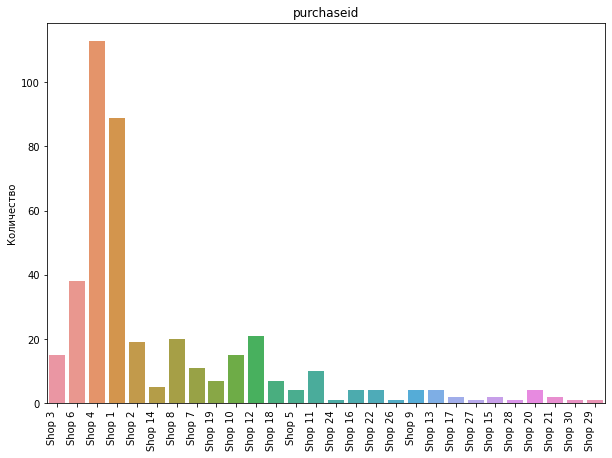

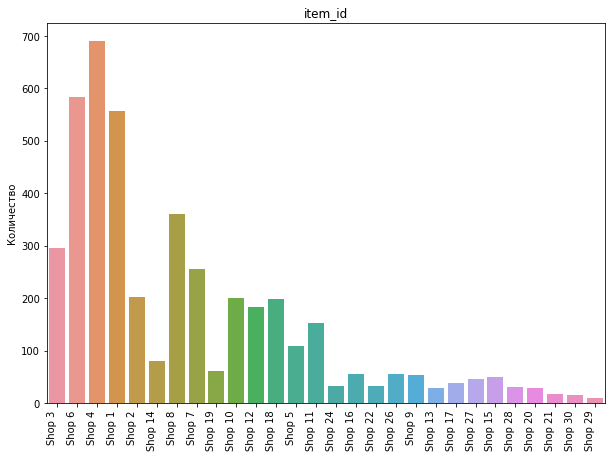

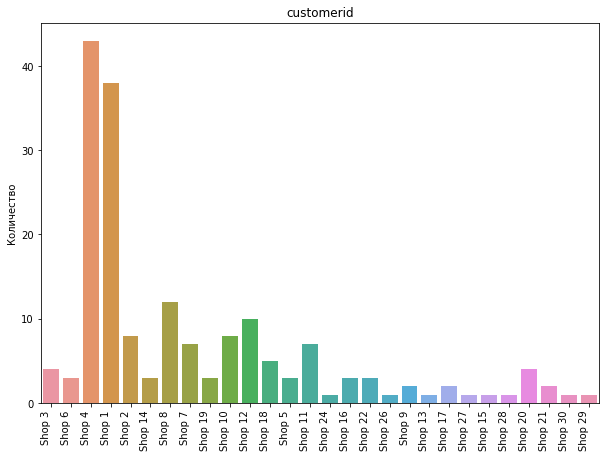

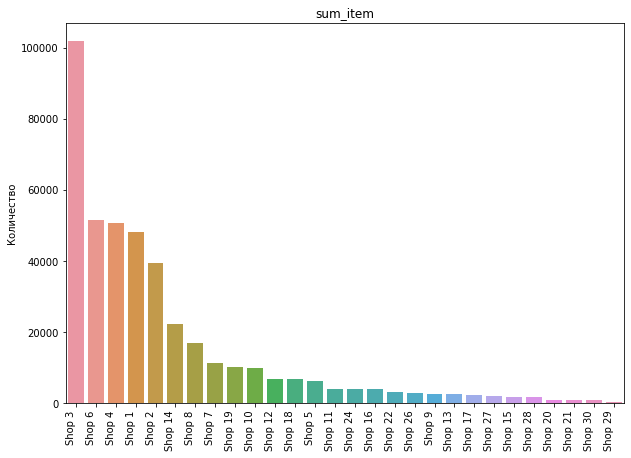

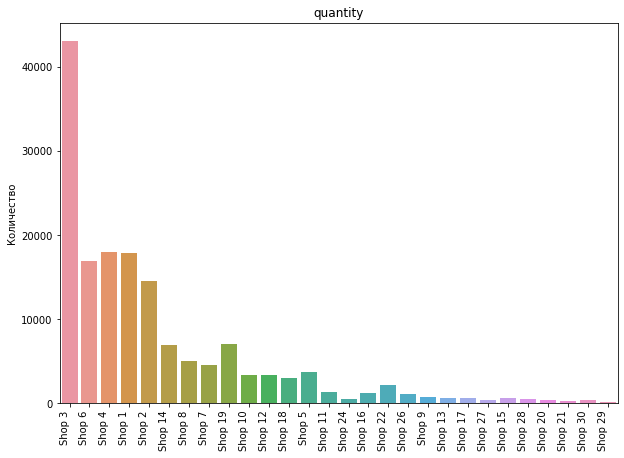

In [16]:
list = ['purchaseid', 'item_id', 'customerid', 'sum_item', 'quantity']

for i in list:
    my_plot('shopid', i, shops_without0, (10, 7))

#### Вывод

В исходной таблице есть данные из 30 магазинов, после корректировки данных остались данные по 29 магазинам. Они рассматривались в данном пункте.

Самый крупный из них по всем показателям - Shop 0. Выручка за изучаемый период тут составила 1 577 827 р. В этом же магазине максимальное количество покупок по программе лояльности.

В остальных магазинах выручка гораздо ниже. По выручке выделяется Shop 3: 101 963р, здесь же было продано большее количество товаров(кроме Shop 0).

Так же выделяются Shop 6, Shop 4, Shop 1. В них выручка находится в пределах 48-51,5 тыс.р. Количество проданных товаров - 17-18тыс.шт. Они же отличаются разнообразностью проданных товаров. Больше чеков и покупателей с ID в Shop 4, Shop 1.

Покупатели приобретали товары по программе лояльности в 4 магазинах: Shop 0, Shop 8(34 покупки), Shop 19(48),Shop 28(30).

Есть 6 магазинов, в которых была совершена всего 1 покупка за весь анализируемый период. И эта покупка приходилась на конец января(с 24.01)-февраль. Возможно новые магазины.

### Анализ товара и его количества

In [17]:
# Сгруппирую данные по товару и суммирую их количество

item = data_new.groupby(['item_id']).agg({'quantity':'sum', 'sum_item' : 'sum'}).reset_index()
item = item.sort_values('quantity', ascending=False)
item.head()

,item_id,quantity,sum_item
2053,84077,10023,2906.670
2396,85123A,9849,30482.655
371,21212,8565,10706.250
2383,85099B,7256,14149.200
1446,22693,6830,7239.800


In [18]:
item.sort_values('sum_item', ascending=False).head()

,item_id,quantity,sum_item
1192,22423,2720,34639.200
2396,85123A,9849,30482.655
590,21623,2070,19095.750
2005,79321,3234,18595.500
1235,22469,5281,17374.490


In [19]:
# ознакомлюсь с общей статистической информацией

item.describe()

,quantity,sum_item
count,2603.000000,2603.000000
mean,291.759124,765.483917
std,676.242059,1943.320654
min,-7589.000000,-28496.695000
25%,14.000000,36.590000
50%,80.000000,193.800000
75%,289.000000,690.790000
max,10023.000000,34639.200000


(-500.0, 2000.0)

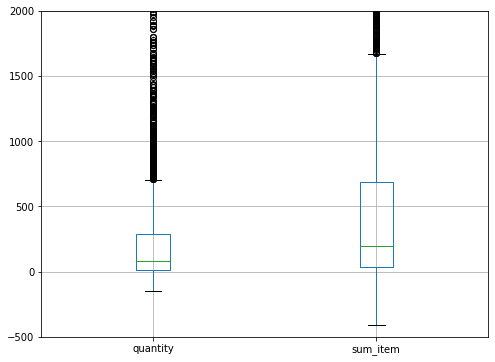

In [20]:
# построю боксплот, чтобы посмотреть размах данных.
# ограничила ось y для более удобного просмотра

item.boxplot(column=['quantity', 'sum_item'], figsize = (8,6))
plt.ylim([-500, 2000])


In [21]:
# рассчитаю границы значений, встречающихся только в 5% случаев

np.quantile(item['quantity'], q=[0.025,0.975])

array([1.0000e+00, 1.8908e+03])

In [22]:
# узнаю, сколько значений выходят за эти границы

drop_quantity = item.query("quantity <= 1.0000e+00 or quantity >= 1.8908e+03")
print(drop_quantity['quantity'].count())
print(drop_quantity['quantity'].sum())
print(drop_quantity['quantity'].sum()/item['quantity'].sum())

240
213136
0.28064557330380313


In [23]:
# рассчитаю границы значений, встречающихся только в 5% случаев

np.quantile(item['sum_item'], q=[0.025,0.975])

array([4.3025000e-01, 5.4724595e+03])

In [24]:
# узнаю, сколько значений выходят за эти границы

drop_sum = item.query("sum_item <= 4.3025000e-01 or sum_item >= 5.4724595e+03")
print(drop_sum['sum_item'].count())
print(drop_sum['sum_item'].sum().round(2))
print(drop_sum['sum_item'].sum()/item['sum_item'].sum())

132
595505.48
0.2988653181898825


#### Вывод

Всего мы рассматриваем 2603 товарных позиции.

Больше всего по количеству были куплены товары:
2053 - 10023шт (2906р)
2396 - 9849шт (30483р)
371 - 8565шт (10706р)
2383 - 7256шт (14149р)
1446 - 6830шт (7240р)

На большую сумму приобрели следующие товары:
1192 - 34639р (2720шт)
2396 - 30483р (9849шт)
590 - 19096р (2070шт)
2005 - 18596р (3234шт)
1235 - 17374р (5281шт)

Боксплот показал, что 75% товаров было продано в количестве до 289 шт. и на сумму - до 691р.

Медианные значения количества и суммы продажи равно 80 шт и 194 р соответственно.

Есть аномальные значения. Они встречаются реже, чем в 5% случаев. При этом вес этих аномальных товаров по обеим метрикам составляет примерно 30% от всего товара. Это достаточно большой объем. Без него считаю, что исследовательский анализ будет не верен. 

Не удаляю эти строки. Получилось, что это выбросы, но ведь с другой стороны получается, что это просто те товары, которые больше покупают люди и удалять их, на мой взгляд, неправильно.

### Период, за который есть данные по покупкам

<AxesSubplot:title={'center':'Анализ количества покупок по датам'}, xlabel='purchasedate', ylabel='Count'>

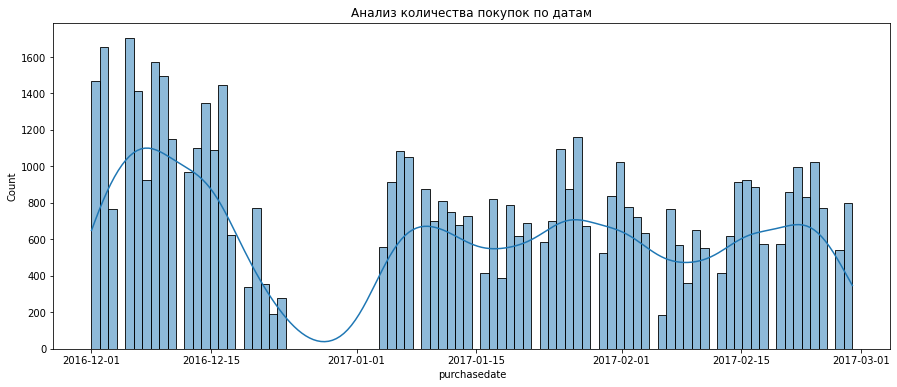

In [25]:
fig, test = plt.subplots(figsize=(15,6))
test.set_title('Анализ количества покупок по датам') 
sns.histplot(data_new['purchasedate'], kde = True, bins = 90)

In [26]:
# выведу, в какие даты было больше всего покупок. первые 20 значений

data_new.groupby('purchasedate').agg({'purchaseid': 'nunique'}).sort_values('purchaseid', ascending = False).head(20)

,purchaseid
purchasedate,
2016-12-02,157
2016-12-16,141
2016-12-08,133
2016-12-09,131
2016-12-14,130
2016-12-01,126
2016-12-06,111
2016-12-05,93
2016-12-15,92


#### Вывод

Изучаемый период - с 01.12.2016 по 28.02.2017. Воскресенье - нерабочий день.
Пик продаж пришелся на первую половину декабря - до 16.12.22. Вообще не было продаж последнюю неделю декабря - первую неделю января. Возможно, это связано с тем, что магазин не работал.

### Анализ покупателей по количеству покупок и сумме чеков

In [27]:
# сгруппирую таблицу по покупателям(у кого есть id) и изучу данные

customers = data_new.groupby('customerid').agg({'purchaseid': 'nunique', 'item_id': 'nunique', 
                                        'quantity': 'sum', 'shopid': 'nunique', 
                                        'purchasedate': ['min', 'max'], 'loyalty_program': 'max', 
                                        'sum_item': 'sum'})
customers.columns = customers.columns.map('_'.join)
customers = customers.sort_values('sum_item_sum', ascending = False).reset_index()
customers = customers.rename(columns={'purchaseid_nunique': 'purchaseid', 'item_id_nunique': 'item_id',
                             'loyalty_program_max': 'loyalty', 'shopid_nunique': 'shopid',
                              'sum_item_sum': 'sum_item', 'quantity_sum': 'quantity'})

customers.head(5)

,customerid,purchaseid,item_id,quantity,shopid,purchasedate_min,purchasedate_max,loyalty,sum_item
0,20325.0,11,281,42817,1,2016-12-20,2017-02-22,0,101301.125
1,23781.0,6,10,9099,1,2016-12-07,2017-02-07,1,55970.180
2,18094.0,3,114,13026,1,2017-01-06,2017-02-15,0,34452.210
3,19835.0,9,251,11035,1,2016-12-02,2017-02-25,0,34001.575
4,20740.0,19,54,10662,1,2016-12-02,2017-02-11,0,33967.175


In [28]:
# посмотрим статистические показатели

customers.describe()

,customerid,purchaseid,item_id,quantity,shopid,loyalty,sum_item
count,1740.000000,1740.000000,1740.000000,1740.000000,1740.000000,1740.000000,1740.000000
mean,20972.990805,2.350575,27.331034,436.464943,1.001149,0.335632,1145.146342
std,1749.146474,2.872021,31.490328,1490.316871,0.033893,0.472347,3946.113280
min,18025.000000,1.000000,1.000000,-8666.000000,1.000000,0.000000,-32922.105000
25%,19469.750000,1.000000,9.000000,73.750000,1.000000,0.000000,205.631250
50%,20963.500000,1.000000,18.000000,164.000000,1.000000,0.000000,442.165000
75%,22540.500000,3.000000,35.000000,368.000000,1.000000,1.000000,934.515000
max,23962.000000,37.000000,395.000000,42817.000000,2.000000,1.000000,101301.125000


(-2500.0, 4000.0)

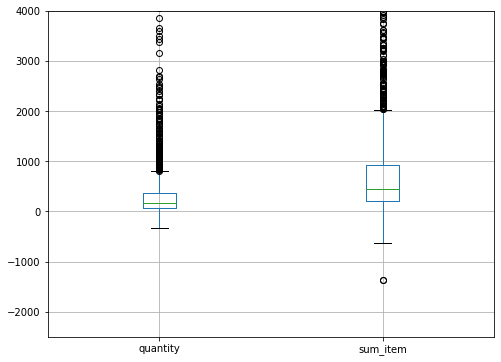

In [29]:
# и на боксплоте наглядно посмотрим данные

customers.boxplot(column=['quantity', 'sum_item'], figsize = (8,6))
plt.ylim([-2500, 4000])

(-20.0, 90.0)

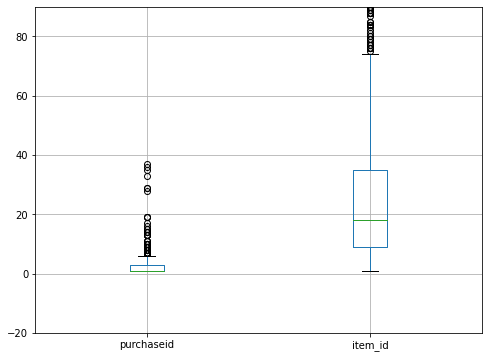

In [30]:
customers.boxplot(column=['purchaseid', 'item_id'], figsize = (8,6))
plt.ylim([-20,90])

#### Вывод

Есть 1740 покупателей, у кого определен ID.

Количество чеков, приходящееся на каждого покупателя в 75% случаях составляет до 3 шт.

По видам купленных товаров, на  1 покупателя приходтся  от 1 до 395 вида, в основном, до 35 видов.

А по количеству товаров 75% значений  - менее 368шт., медианное значение - 164 шт.

Чаще всего покупки совершались в 1 магазине.

Сумма выручки от 1 человека обычно составляет до 934р.(с учетом возвратов).

### Анализ чеков

Выделила отдельным пукнктом, так как этот параметр хочу проанализировать без учета возвратов

In [31]:
data_cheque = data_new[data_new['quantity'] > 0].copy(deep=True)
data_cheque_1 = data_cheque.groupby('purchaseid').agg({'item_id': 'nunique', 'quantity': 'sum',
                                        'shopid': 'max', 
                                        'purchasedate': 'max', 'loyalty_program': 'max', 
                                        'sum_item': 'sum'})
data_cheque_1 = data_cheque_1.sort_values('sum_item', ascending = False).reset_index()
data_cheque_1.head()

,purchaseid,item_id,quantity,shopid,purchasedate,loyalty_program,sum_item
0,541431,1,74214,Shop 0,2017-01-18,0,77182.560
1,541220,39,6157,Shop 6,2017-01-14,0,26374.580
2,537659,9,3680,Shop 0,2016-12-07,1,23093.560
3,540815,3,7041,Shop 0,2017-01-11,0,22607.095
4,543989,69,8315,Shop 2,2017-02-15,0,22330.545


In [32]:
data_cheque_1.describe()

,item_id,quantity,loyalty_program,sum_item
count,3329.000000,3329.000000,3329.000000,3329.000000
mean,16.113848,258.259237,0.336437,654.617926
std,15.576057,1382.155062,0.472561,1921.562078
min,1.000000,1.000000,0.000000,0.950000
25%,6.000000,53.000000,0.000000,166.295000
50%,12.000000,116.000000,0.000000,346.130000
75%,21.000000,235.000000,1.000000,619.225000
max,171.000000,74214.000000,1.000000,77182.560000


#### Вывод

За изучаемый период вышло 3329 покупок.
В чеке обычно до 21 позиции, количество товаров  - до 235шт., чаще чек пробивался без учета программы лояльности, 
Сумма чека в 75% случаев - до 619 р.

### Анализ возвратов

In [33]:
data_return = data_new[data_new['quantity'] < 0].copy(deep=True)
data_return

,purchaseid,item_id,quantity,purchasedate,customerid,shopid,loyalty_program,price_per_one,sum_item
43,C539944,22776,-2,2016-12-23,20239.0,Shop 0,0,14.955,-29.910
78,C542910,20726,-2,2017-02-01,23190.0,Shop 0,1,4.130,-8.260
80,C542426,22418,-25,2017-01-28,19825.0,Shop 0,0,1.645,-41.125
176,C539726,22791,-11,2016-12-21,22686.0,Shop 0,1,1.855,-20.405
242,C544034,21878,-2,2017-02-15,20380.0,Shop 0,0,1.240,-2.480
...,...,...,...,...,...,...,...,...,...
72086,C544397,22063,-2,2017-02-18,18141.0,Shop 8,0,5.790,-11.580
72167,C540246,79320,-2,2017-01-05,18760.0,Shop 0,0,4.950,-9.900
72193,C539467,22801,-2,2016-12-19,20723.0,Shop 0,0,5.605,-11.210
72217,C540847,22197,-3,2017-01-11,19137.0,Shop 0,0,1.240,-3.720


In [34]:
item_return = data_return.groupby(['item_id']).agg({'quantity':'sum', 'sum_item' : 'sum'}).reset_index()
item_return = item_return.sort_values('quantity', ascending=False)
item_return.tail()

,item_id,quantity,sum_item
26,20733,-301,-249.83
751,85123A,-558,-1727.01
1,15036,-650,-650.00
673,84347,-9368,-35176.84
583,23166,-74216,-77184.64


In [35]:
item_return.sort_values('sum_item', ascending=False).tail()

,item_id,quantity,sum_item
510,22838,-106,-3092.02
348,22423,-284,-3616.74
779,M,-284,-3621.00
673,84347,-9368,-35176.84
583,23166,-74216,-77184.64


In [36]:
print('Количество чеков с возвратами:',len(data_return['purchaseid'].unique()))
print('Возвращено', len(data_return['item_id'].unique()), 'видов товаров,',
      'общее количество -', abs(data_return['quantity'].sum()),'штук')
print('Число покупателей, оформивших возврат:',len(data_return['customerid'].unique()),'человека')
print('Общая сумма возвратов за анализируемый период:',abs(data_return['sum_item'].sum()),'рублей')

print('Общая сумма поступлений:',data_cheque['sum_item'].sum().round(2),'рублей')
print('То есть доля возвратов составляет:',
      abs(100 * (data_return['sum_item'].sum() / data_cheque_1['sum_item'].sum()).round(4)),'%')

Количество чеков с возвратами: 761
Возвращено 781 видов товаров, общее количество - 100296 штук
Число покупателей, оформивших возврат: 522 человека
Общая сумма возвратов за анализируемый период: 186668.44 рублей
Общая сумма поступлений: 2179223.07 рублей
То есть доля возвратов составляет: 8.57 %


#### Вывод

Основной вывод выше. Добавлю самые возвращаемые товары:

84347	- возвращено 9368шт на 35177р 

23166	- возвращено 74216шт на	77185р

Посмотрела строки с оборотом этих товаров, были разовые крупные возвраты, поэтому такое количество. Скорее это частные случаи, чем какая-то закономерность.

## Анализ программы лояльности

In [37]:
# найдем долю клиентов, которые участвуют в программе лояльности

loyalty_customer = data_new.pivot_table(index = 'loyalty_program', values = 'customerid', 
                                        aggfunc = 'nunique').reset_index()
loyalty_customer['%'] = (100 * loyalty_customer['customerid'] / loyalty_customer['customerid'].sum()).round(2)
loyalty_customer

,loyalty_program,customerid,%
0,0,1156,66.44
1,1,584,33.56


In [38]:
# соберем данные только покупок, совершенных по программе лояльности, без учета возвратов

loyalty = data_cheque[data_cheque['loyalty_program'] == 1].copy(deep=True)

# возвраты участников программы лояльности
loyalty_return = data_return[data_return['loyalty_program'] == 1].copy(deep=True)

In [39]:
# соберем данные покупок, совершенных без использования програмы лояльности, без учета возвратов

without_loyalty = data_cheque[data_cheque['loyalty_program'] == 0].copy(deep=True)

# и возвраты
without_loyalty_return = data_return[data_return['loyalty_program'] == 0].copy(deep=True)

In [40]:
# сколько участников в каждом магазине сети

loyalty_shops = data_new[data_new['loyalty_program'] == 1].pivot_table(index = ['loyalty_program', 
                                                                                'shopid'], values = 'customerid', 
                                                                       aggfunc = 'nunique').reset_index()
loyalty_shops

,loyalty_program,shopid,customerid
0,1,Shop 0,581
1,1,Shop 19,1
2,1,Shop 28,1
3,1,Shop 8,1


In [41]:
# Проанализируем клиентов, участвующих в программе и не участвующих( без учета возвратов)

loyalty_all = data_cheque.groupby('loyalty_program').agg({'purchaseid': 'nunique','customerid': 'nunique','item_id': 'nunique', 
                                                       'quantity': 'sum','shopid': 'nunique', 'sum_item': 'sum'})
loyalty_all = loyalty_all.reset_index()

# средний чек
loyalty_all['mean_cheque'] = (loyalty_all['sum_item'] / loyalty_all['purchaseid']).round(2) 

# средняя выручка с клиента
loyalty_all['revenue_customer'] = (loyalty_all['sum_item'] / loyalty_all['customerid']).round(2) 

# сколько видов товаров в среднем покупает 1 клиент
loyalty_all['customer_item'] = (loyalty_all['item_id'] / loyalty_all['customerid']).round(2)

# какое количество товаров покупает в среднем 1 клиент
loyalty_all['quantity_item'] = (loyalty_all['quantity'] / loyalty_all['customerid']).round(2)

# сколько покупок в среднем приходится на 1 человека
loyalty_all['purchase_customer'] = (loyalty_all['purchaseid'] / loyalty_all['customerid']).round(2)
loyalty_all

,loyalty_program,purchaseid,customerid,item_id,quantity,shopid,sum_item,mean_cheque,revenue_customer,customer_item,quantity_item,purchase_customer
0,0,2209,1110,2410,625915,28,1586802.290,718.34,1429.55,2.17,563.89,1.99
1,1,1120,561,2166,233830,4,592420.785,528.95,1056.01,3.86,416.81,2.00


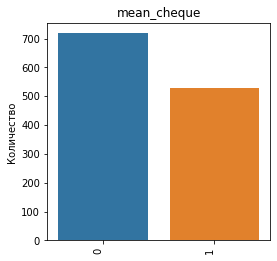

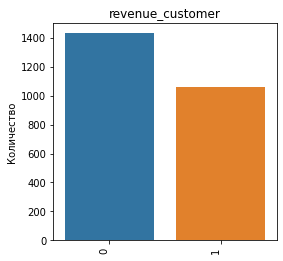

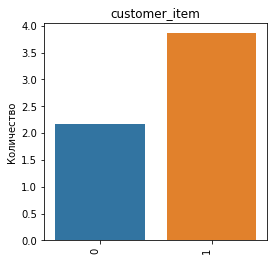

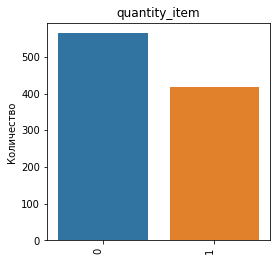

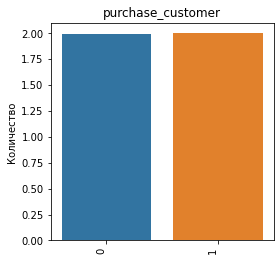

In [42]:
# и посмотрим на графиках полученные значения

list_2 = ['mean_cheque', 'revenue_customer', 'customer_item', 'quantity_item', 'purchase_customer']

for i in list_2:
    my_plot('loyalty_program', i, loyalty_all, (4, 4))

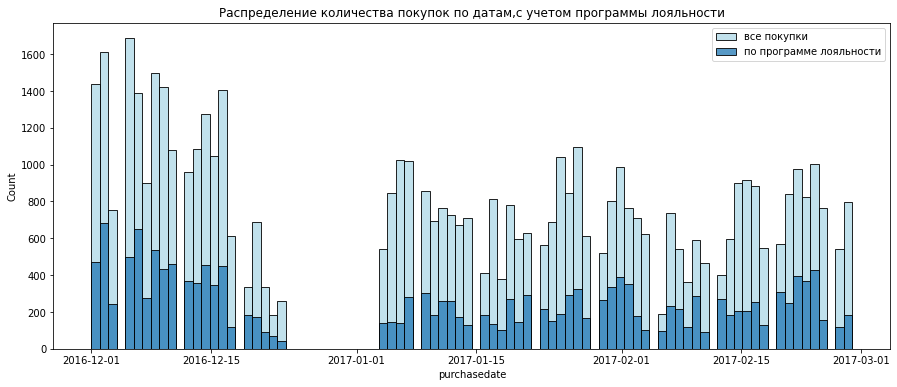

In [43]:
# теперь хочу посмотреть, как распределялись покупки по датам, без учета возвратов
# построю данные по всем покупкам в общем и по лояльным клиентам

fig, test = plt.subplots(figsize=(15,6))
test.set_title('Распределение количества покупок по датам,с учетом программы лояльности') 
sns.histplot(data_cheque['purchasedate'], bins = 90, color = 'lightblue', label='все покупки')
sns.histplot(loyalty['purchasedate'], bins = 90, label='по программе лояльности')
plt.legend()

In [44]:
# посмотрю возвраты

loyalty_return_1= data_return.groupby('loyalty_program').agg({'purchaseid': 'nunique',
                                                       'customerid': 'nunique','item_id': 'nunique', 
                                                       'quantity': 'sum','shopid': 'nunique', 
                                                       'sum_item': 'sum'})
loyalty_return_1 = loyalty_return_1.reset_index()
loyalty_return_1

,loyalty_program,purchaseid,customerid,item_id,quantity,shopid,sum_item
0,0,550,363,659,-95631,17,-168109.175
1,1,211,159,296,-4665,2,-18559.265


In [45]:
print('Процент возврата товаров среди клиентов, не находящихся в программе лояльности:',
      (100 * abs(loyalty_return_1.loc[0, 'sum_item'] / loyalty_all.loc[0, 'sum_item'])).round(2),'%')

Процент возврата товаров среди клиентов, не находящихся в программе лояльности: 10.59 %


In [46]:
print('Процент возврата товаров среди клиентов из программы лояльности:',
      (100 * abs(loyalty_return_1.loc[1, 'sum_item'] / loyalty_all.loc[1, 'sum_item'])).round(2),'%')

Процент возврата товаров среди клиентов из программы лояльности: 3.13 %


In [47]:
# даты первых покупок в анализируемом периоде

loyalty_mindata = loyalty.pivot_table(index = 'customerid', values = 'purchasedate', 
                                      aggfunc = 'min').reset_index()

<AxesSubplot:title={'center':'Распределение первой даты покупки'}, xlabel='purchasedate', ylabel='Count'>

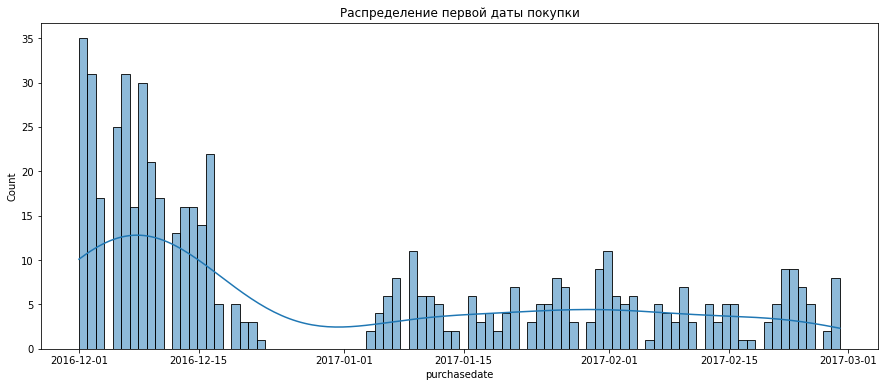

In [48]:
# распределение первой даты покупки

fig, test = plt.subplots(figsize=(15,6))
test.set_title('Распределение первой даты покупки') 
sns.histplot(loyalty_mindata['purchasedate'], kde = True, bins = 90)

### Вывод

В программе лояльности участвует 33,56% покупателей, всего 584 человека.

581 окупает в Shop 0 и по 1 в Shop 19, Shop 28 и Shop 8.

Общий анализ показал, что средний чек среди покупателей из программы лояльности составляет 529р, а у обычных покупателей - 718р.

Средняя выручка на клиента вышла 1056 и 1430р соответственно.

Сколько видов товаров приходится на 1 клиента(округленно): из программы лояльности - 4, без программы - 2.

Количество товаров, которое купил в среднем 1 клиент за изучаемый период: 417(лояльный) и 564(обычный).

График распределения до датам не выявило ничего необычного. Примерно в одинаковом соотношении выглядят покупки.

Процент возврата товаров среди клиентов, не находящихся в программе лояльности: 10.59 %

Процент возврата товаров среди клиентов из программы лояльности: 3.13 %, то есть в 3 раза меньше.

А если смотреть возвраты по количеству, то получается 15% возвратов у обычных клиентов и 2% у клиентов из программы.

Анализ дат первых покупок не показал ничего интересного. Всплеск есть вначале, но это объясняется и соответствием общей картине, и тем, что это не обязательно первая покупка клиента в качестве лояльного, а может быть просто первая учтенная у нас в данных покупка.

## Проверка статистических гипотез.

### Корректировка выбросов

Для проверки гиптез выбросы следует убрать. Подготовлю данные для работы.

In [49]:
# Выбросы количества товаров, купленных участниками программы лояльности

np.quantile(loyalty['quantity'], q=[0.025,0.975])

array([ 1., 71.])

In [50]:
loyalty_t = loyalty.loc[loyalty['quantity'] > 1.]
loyalty_t = loyalty_t.loc[loyalty_t['quantity'] < 71.]

In [51]:
# Выбросы количества товаров, купленных обычными покупателями

np.quantile(without_loyalty['quantity'], q=[0.025,0.975])

array([ 1., 95.])

In [52]:
without_loyalty_t = without_loyalty.loc[without_loyalty['quantity'] > 1.]
without_loyalty_t = without_loyalty_t.loc[without_loyalty_t['quantity'] < 95.]

In [53]:
# Очистим от выбросов данные по возвратам по программе лояльности

np.quantile(loyalty_return['sum_item'], q=[0.025,0.975])

array([-298.69 ,   -2.855])

In [54]:
loyalty_return_t = loyalty_return.loc[loyalty_return['sum_item'] > -298.69]
loyalty_return_t = loyalty_return_t.loc[loyalty_return_t['sum_item'] < -2.855]

In [55]:
# Очистим данные по возвратам от обычных клиентов

np.quantile(without_loyalty_return['sum_item'], q=[0.025,0.975])

array([-216.451125,   -3.1     ])

In [56]:
without_loyalty_return_t = without_loyalty_return.loc[without_loyalty_return['sum_item'] > -298.69]
without_loyalty_return_t = without_loyalty_return_t.loc[without_loyalty_return_t['sum_item'] < -2.855]

### Гипотеза 2: Участники программы лояльности возвращают товаров на сумму меньше, чем не из программы.

H0 Средняя сумма возвратов участников программы лояльности равна средней сумме возвратов других покупателей

H1 Средняя сумма возвратов участников программы лояльности меньше средней суммы возврата других покупателей

Односторонняя гипотеза.

In [57]:
interested_value = without_loyalty_return_t['sum_item'].mean()

alpha = 0.05 # уровень статистической значимости

return_1 = loyalty_return_t['sum_item']
return_0 = interested_value

results = st.ttest_1samp(return_1, return_0)

# тест односторонний: p-value будет в два раза меньше
print('p-значение:', results.pvalue / 2)

# тест односторонний влево:
# отвергаем гипотезу только тогда, когда выборочное среднее значимо меньше предполагаемого значения
# так как данные метрики отрицательные, то буду сравнивать по абсолютному значению 
if (results.pvalue / 2 < alpha) and (abs(return_1.mean()) < abs(return_0)):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не отвергаем нулевую гипотезу")

p-значение: 0.03567920587038016
Отвергаем нулевую гипотезу


#### Вывод

Гипотезу отвергаем: Средняя сумма возвратов участников программы лояльности меньше средней суммы возвратов других покупателей.

### Гипотеза 3: Среднее количество купленных товаров за изучаемый период одинаково для всех покупателей.

H0 Количество товаров, купленных клиентами - участниками программы равно количеству товаров простых покупателей

H1 Количество товаров, купленных клиентами - участниками программы не равно количеству товаров простых покупателей

Это двусторонняя гипотеза. Для ее проверки буду использовать t-тест.

In [58]:
alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвегнем гипотезу

quantity_mean_1 = loyalty_t['quantity']
quantity_mean_0 = without_loyalty_t['quantity']

results = st.ttest_ind(quantity_mean_0, quantity_mean_1, equal_var = False)
print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  3.513253651303071e-70
Отвергаем нулевую гипотезу


#### Вывод

Гипотеза отвергнута. Значит, что количество товаров, купленных клиентами - участниками программы не равно количеству товаров, которые приобрели покупатели, не участвующие в программе.

## Общие выводы

1. Изучаемый период - с 01.12.2016 по 28.02.2017. Пик продаж пришелся на первую половину декабря - до 16.12.22. Скорее всего это связано с предпраздничными покупками.
2. Самый крупный из магазинов по всем показателям - Shop 0. Выручка за изучаемый период тут составила 1 577 827 р. В этом же магазине максимальное количество покупок по программе лояльности. В остальных магазинах выручка гораздо ниже.   
   Можно выделить Shop 3: 101 963р, здесь же было продано большее количество товаров(кроме Shop 0). 
   Так же выделяются Shop 6, Shop 4, Shop 1. В них выручка находится в пределах 48-51,5 тыс.р. Количество проданных товаров - 17-18тыс.шт. Они же отличаются разнообразностью проданных товаров. Больше чеков и покупателей с ID в Shop 4, Shop 1.
3. Покупатели приобретали товары по программе лояльности всего в 4 магазинах: Shop 0, Shop 8(34 покупки), Shop 19(48),Shop 28(30).
4. Есть 6 магазинов, в которых была совершена всего 1 покупка за весь анализируемый период. И эта покупка приходилась на конец января(с 24.01)-февраль. Возможно, это новые магазины.
5. Больше всего по количеству были куплены товары: 
* 2053 - 10023шт (2906р)
* 2396 - 9849шт (30483р)
* 371 - 8565шт (10706р)
* 2383 - 7256шт (14149р)
* 1446 - 6830шт (7240р)
6. На наибольшую сумму приобрели следующие товары:
* 1192 - 34639р (2720шт)
* 2396 - 30483р (9849шт)
* 590 - 19096р (2070шт)
* 2005 - 18596р (3234шт)
* 1235 - 17374р (5281шт)
7. Количество чеков, приходящееся на каждого покупателя в 75% случаях составляет до 3 шт. 
8. По видам купленных товаров, на 1 покупателя приходится, в основном, до 35 видов.
9. Чаще всего покупатель совершает покупки в 1 магазине
10. Сумма выручки от 1 человека составила в большинстве случаев до 934р.(с учетом возвратов).
11. За изучаемый период вышло 3329 покупок. В чеке обычно до 21 позиции, количество товаров - до 235шт., чаще чек пробивался без учета программы лояльности, Сумма чека в 75% случаев - до 619 р.
12. Количество чеков с возвратами: 761
* Возвращено 781 видов товаров, общее количество - 100296 штук
* Число покупателей, оформивших возврат: 522 человека
* Общая сумма возвратов за анализируемый период: 186 668.44 рублей, общая сумма поступлений: 2 179 223.07 рублей. То есть доля возвратов составляет: 8.57 %

  Анализ программы лояльности показал:
1. В программе лояльности участвует 33,56% покупателей, всего 584 человека.
2. Из них 581 окупает в Shop 0 и по 1 в Shop 19, Shop 28 и Shop 8.
3. Средний чек среди покупателей из программы лояльности составляет 718р, а у обычных покупателей - 529р.
4. 1 клиент из программы лояльности покупает в среднем 4 вида товаров, без программы - 2.
5. Количество товаров, которое купил в среднем 1 клиент за изучаемый период: 417(лояльный) и 564(обычный).
6. График распределения до датам показал, что примерно 30% покупок каждый рабочий день приходится на лояльных покупателей. Это соответствует общей доле таких клиентов.
7. Процент возврата товаров среди клиентов, не находящихся в программе лояльности: 10.59%, процент возврата товаров среди клиентов из программы лояльности: 3.13 %, то есть в 3 раза меньше.
   Если смотреть возвраты по количеству, то получается 15% возвратов у обычных клиентов и 2% у клиентов из программы.
   Средняя сумма возвратов участников программы лояльности также меньше средней суммы возврата других покупателей

   **Общие рекомендации:**
1. Проанализировать финансовую деятельность всех магазинов. Сделать выводы, возможно ли их дальнейшее развитие или, возможно, часть точек можно сократить и больше заниматься развитием остальных.
2. Следует расширить анализируемые параметры для оценки эффективности программы лояльности: добавить информацию о подарках, скидках и прочих привилегия; затраты на программу.
   
   По результатам анализа тех данных, которые были предоставлены, можно сделать вывод, что, несмотря на то, что средние рассчитанные показатели за анализируемый период: средняя выручка, чек - выше у покупателей, не участвующих в программе лояльности, но есть и положительные характеристики: возвратов среди клиентов, участвующих в программе, гораздо меньше, в 3 раза, если смотреть по сумме покупок. Кроме того, лояльные клиенты покупают более широкий ассортимент товаров.